In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [4]:
df = pd.read_csv("dataset/train.csv")

X = df.drop("price_range", axis=1)
y = df["price_range"]
print("X şekli:", X.shape)
print("y şekli:", y.shape)
print("\nSınıf dağılımı:")
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X şekli: (2000, 20)
y şekli: (2000,)

Sınıf dağılımı:
price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64


In [5]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=3)
grid.fit(X_train_scaled, y_train)

print("\nEn iyi hiperparametreler (GridSearchCV):")
print(grid.best_params_)
print("En iyi CV skoru (train üzeri 3-fold ortalama):", grid.best_score_)

# En iyi bulunan SVM modelini alalım
best_svm = grid.best_estimator_

train_pred = best_svm.predict(X_train_scaled)
test_pred = best_svm.predict(X_test_scaled)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print("\nTrain accuracy:", train_acc)
print("Test accuracy:", test_acc)


En iyi hiperparametreler (GridSearchCV):
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
En iyi CV skoru (train üzeri 3-fold ortalama): 0.9075007085420898

Train accuracy: 0.93875
Test accuracy: 0.93


In [7]:
feature_names = X.columns

np.random.seed(42)
background_size = 100
explained_size = 50

idx_bg = np.random.choice(X_train_scaled.shape[0], background_size, replace=False)
idx_explain = np.random.choice(X_test_scaled.shape[0], explained_size, replace=False)

X_bg = X_train_scaled[idx_bg]
X_explain = X_test_scaled[idx_explain]
y_explain = y_test.iloc[idx_explain].values

In [11]:
models = {}

# 1) SVM (rbf, probability=True)
# svm_rbf = SVC(C=10, gamma=0.001, kernel="rbf", probability=True, random_state=42)
# svm_rbf.fit(X_train_scaled, y_train)
# models["SVM_rbf"] = ("kernel", svm_rbf)

# 2) Logistic Regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
models["LogReg"] = ("linear", log_reg)

# 3) Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)  # ağaç için ölçek şart değil
models["RandomForest"] = ("tree", rf)

In [12]:
import shap

def compute_shap_for_model(name, model_type, model, X_bg, X_explain, feature_names):
    print(f"\n=== {name} için SHAP hesabı ===")

    if model_type == "tree":
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_explain)

    elif model_type == "linear":
        explainer = shap.LinearExplainer(model, X_bg, feature_perturbation="interventional")
        shap_values = explainer.shap_values(X_explain)

    else:  # "kernel" -> SVM gibi modeller
        f = lambda x: model.predict_proba(x)
        explainer = shap.KernelExplainer(f, X_bg)
        shap_values = explainer.shap_values(X_explain)

    # Genel önem grafiği
    shap.summary_plot(
        shap_values,
        X_explain,
        feature_names=feature_names,
        plot_type="bar",
        show=True
    )

    return explainer, shap_values


=== LogReg için SHAP hesabı ===


c:\Users\furkan\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
C:\Users\furkan\AppData\Local\Temp\ipykernel_26364\2328525649.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


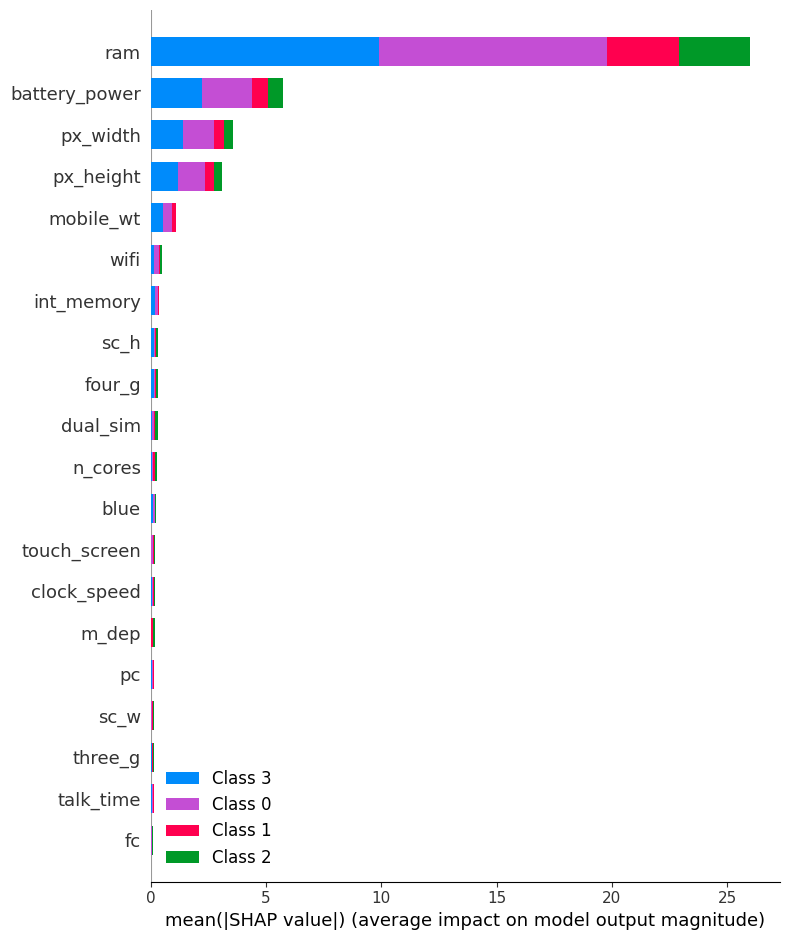


=== RandomForest için SHAP hesabı ===


C:\Users\furkan\AppData\Local\Temp\ipykernel_26364\2328525649.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


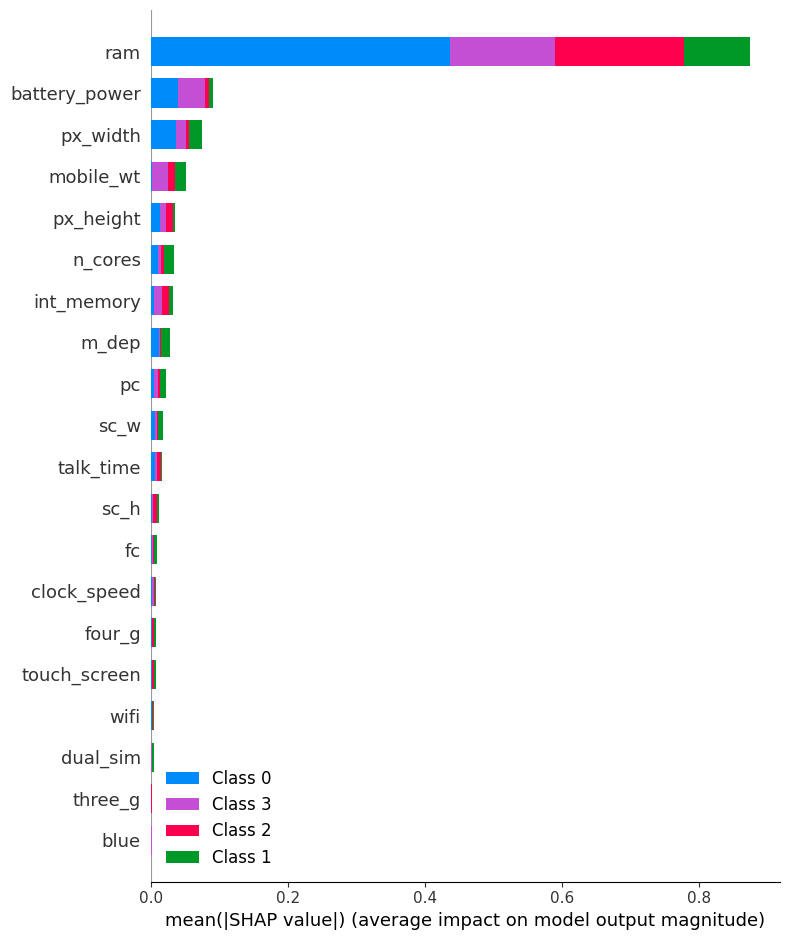

In [13]:
explainers = {}
shap_results = {}

for name, (mtype, model) in models.items():
    explainer, shap_values = compute_shap_for_model(
        name, mtype, model, X_bg, X_explain, feature_names
    )
    explainers[name] = explainer
    shap_results[name] = shap_values